In [1]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Start the Spark session
spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())

In [2]:
#1. Load data
rawdata = spark.read.options(header='True', inferSchema='True').format("csv").load("FC-Churn.csv")

In [3]:
#2.EDA

# Print the schema and types
rawdata.printSchema()

# Displaying a few rows
rawdata.toPandas()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7047,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7048,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7049,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7050,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
#Statistic describtion of the columns
rawdata.summary().toPandas()

,summary,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,count,7052,7052,7052,7052,7052,7052,7052,7052,7052,...,7052,7052,7052,7052,7052,7052,7052,7052,7052,7052
1,mean,None,None,0.16222348269994327,None,None,33.88499716392513,None,None,None,...,None,None,None,None,None,None,None,65.16186188315376,2313.343161482747,None
2,stddev,None,None,0.36868184009892613,None,None,121.45820495696698,None,None,None,...,None,None,None,None,None,None,None,42.33977626784554,3205.57623018018,None
3,min,0000-AAAAA,Female,0,No,No,-1,No,No,DSL,...,NA,No,No,No,Month-to-month,No,Bank transfer (automatic),-34.6,,No
4,25%,None,None,0,None,None,9,None,None,None,...,None,None,None,None,None,None,None,35.45,400.3,None
5,50%,None,None,0,None,None,29,None,None,None,...,None,None,None,None,None,None,None,70.35,1396.9,None
6,75%,None,None,0,None,None,55,None,None,None,...,None,None,None,None,None,None,None,89.85,3794.5,None
7,max,9999-IAZLT,NA,1,Yes,Yes,10000,Yes,Yes,No,...,Yes,Yes,Yes,Yes,year,Yes,Mailed check,2450.75,999.9,Yes


In [5]:
# Display summary statistics for all numeric columns
rawdata.describe(["tenure", "MonthlyCharges", "TotalCharges"]).show()

+-------+------------------+-----------------+-----------------+
|summary|            tenure|   MonthlyCharges|     TotalCharges|
+-------+------------------+-----------------+-----------------+
|  count|              7052|             7052|             7052|
|   mean| 33.88499716392513|65.16186188315376|2313.343161482747|
| stddev|121.45820495696698|42.33977626784554| 3205.57623018018|
|    min|                -1|            -34.6|                 |
|    max|             10000|          2450.75|            999.9|
+-------+------------------+-----------------+-----------------+



In [6]:
# The min for tenure is (-1) months
# The min for monthly charges (-34.6)
# min for totalcharges (empty value)

In [7]:
rawdata.groupBy("monthlyCharges").count().orderBy("monthlyCharges").show()

+--------------+-----+
|monthlyCharges|count|
+--------------+-----+
|         -34.6|    1|
|         -1.55|    1|
|           0.0|    1|
|          1.45|    1|
|         18.25|    1|
|          18.4|    1|
|         18.55|    1|
|          18.7|    2|
|         18.75|    1|
|          18.8|    8|
|         18.85|    5|
|          18.9|    2|
|         18.95|    6|
|          19.0|    7|
|         19.05|    9|
|          19.1|   12|
|         19.15|   11|
|          19.2|   17|
|         19.25|   18|
|          19.3|   24|
+--------------+-----+
only showing top 20 rows



In [8]:
rawdata.groupBy("Tenure").count().orderBy("Tenure").show()

+------+-----+
|Tenure|count|
+------+-----+
|    -1|    1|
|     0|   11|
|     1|  614|
|     2|  238|
|     3|  200|
|     4|  177|
|     5|  133|
|     6|  110|
|     7|  131|
|     8|  123|
|     9|  119|
|    10|  116|
|    11|   99|
|    12|  117|
|    13|  109|
|    14|   76|
|    15|   99|
|    16|   80|
|    17|   87|
|    18|   97|
+------+-----+
only showing top 20 rows



In [9]:
#Display the value counts of each columns 
columns = rawdata.columns
for col in columns:
    rawdata.groupBy(col).count().orderBy(col).show()


+----------+-----+
|customerID|count|
+----------+-----+
|0000-AAAAA|    1|
|0002-ORFBO|    1|
|0003-MKNFE|    1|
|0004-TLHLJ|    1|
|0011-IGKFF|    1|
|0013-EXCHZ|    1|
|0013-MHZWF|    1|
|0013-SMEOE|    1|
|0014-BMAQU|    1|
|0015-UOCOJ|    1|
|0016-QLJIS|    1|
|0017-DINOC|    1|
|0017-IUDMW|    1|
|0018-NYROU|    1|
|0019-EFAEP|    1|
|0019-GFNTW|    1|
|0020-INWCK|    1|
|0020-JDNXP|    1|
|0021-IKXGC|    1|
|0022-TCJCI|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3491|
|  Male| 3560|
|    NA|    1|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|            0| 5908|
|            1| 1144|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3645|
|    Yes| 3407|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4940|
|       Yes| 2112|
+----------+-----+

+------+-----+
|tenure|count|
+------+-----+
|    -1|    1|
|     0

<Axes: xlabel='Churn', ylabel='count'>

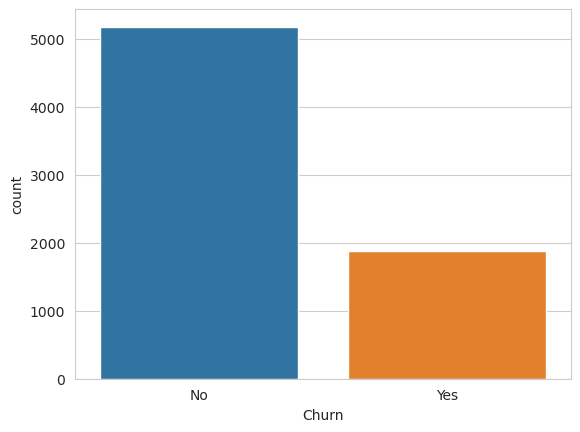

In [10]:
pandasDF = rawdata.toPandas()
sns.set_style('whitegrid')
sns.countplot(x='Churn',data=pandasDF)

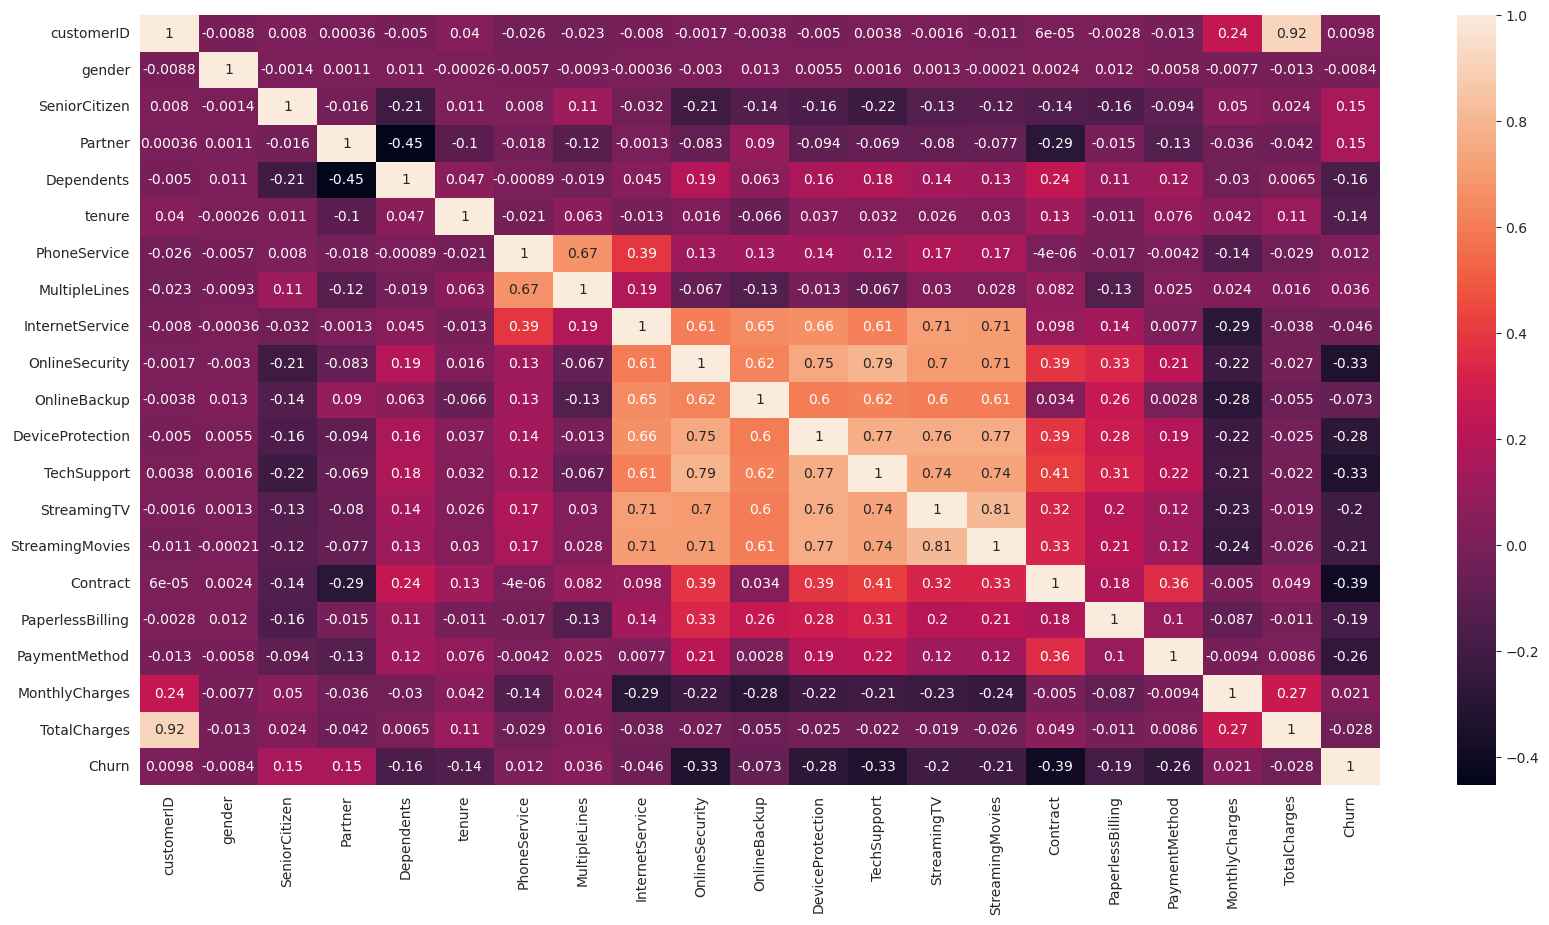

In [11]:
corrDF = pandasDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(20,10))
sns.heatmap(corrDF, annot=True)
plt.show()

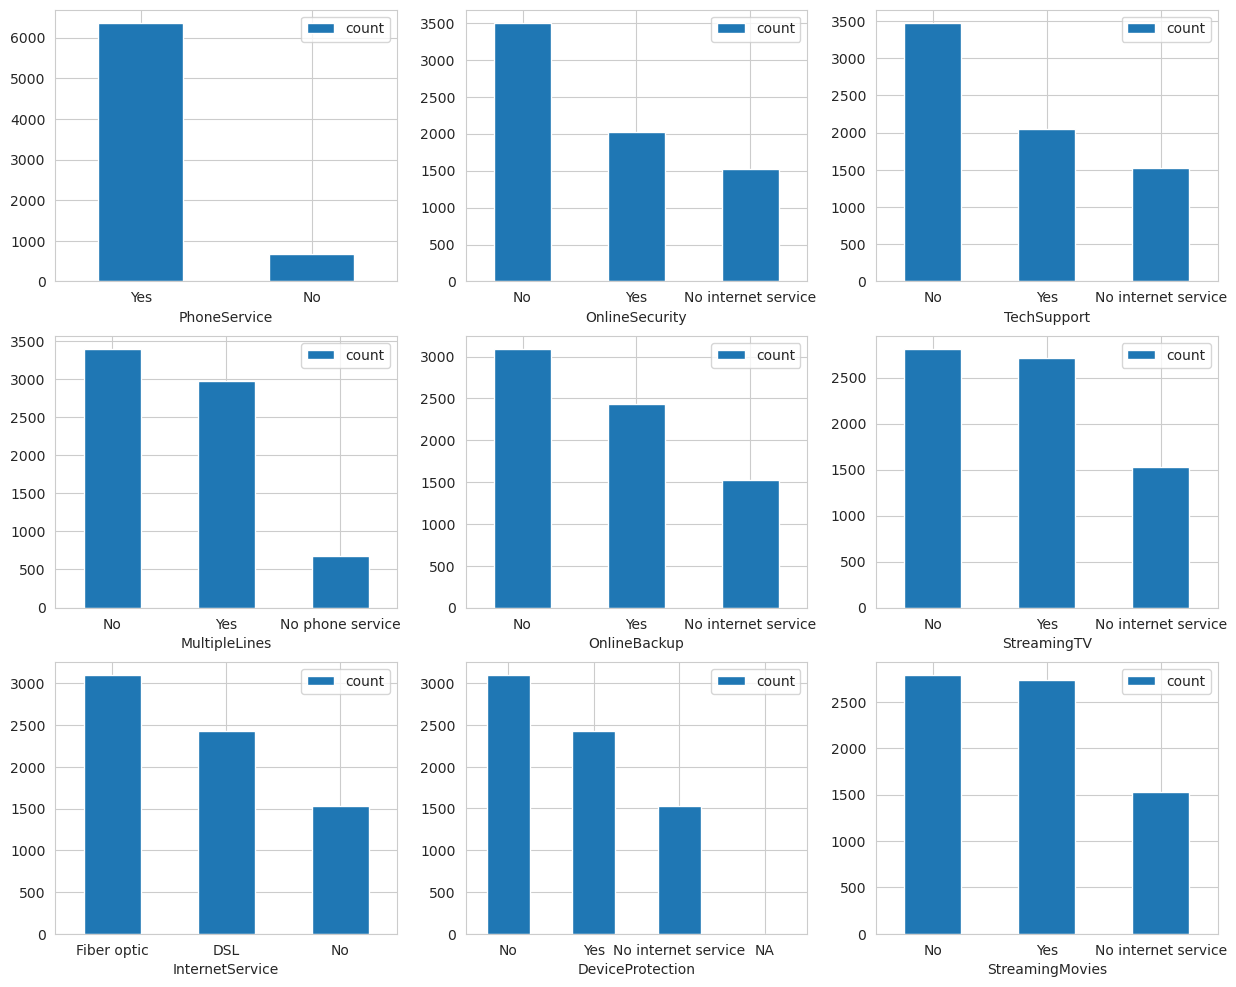

In [12]:
from pyspark.sql.functions import col

services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = rawdata.groupBy(item).count().orderBy(col("count").desc()).toPandas().plot(kind = 'bar', x=item, y='count', ax=axes[i,0], rot=0)
    elif i >=3 and i < 6:
        ax = rawdata.groupBy(item).count().orderBy(col("count").desc()).toPandas().plot(kind = 'bar', x=item, y='count', ax=axes[i-3,1], rot=0)
    elif i < 9:
        ax = rawdata.groupBy(item).count().orderBy(col("count").desc()).toPandas().plot(kind = 'bar', x=item, y='count', ax=axes[i-6,2], rot=0)
    ax.set_title('')


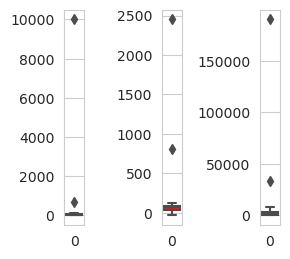

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when

def display_outliers(data):
    """
    Display boxplots for potential outlier columns.
    
    Parameters:
    - data: Spark DataFrame.
    """
    
    # Handle non-numeric values in "TotalCharges" (replace them with NaN)
    data = data.withColumn("TotalCharges", when(data["TotalCharges"].cast("string") == ' ', None).otherwise(data["TotalCharges"]))
    
    # Convert the necessary columns of the Spark DataFrame to a Pandas DataFrame
    numericDF = data.select(['tenure', 'MonthlyCharges', 'TotalCharges']).toPandas()

    l = numericDF.columns.values
    number_of_columns = 3
    number_of_rows = int(np.round((len(l)-1)/number_of_columns))
    
    plt.figure(figsize=(number_of_columns, 5 * number_of_rows))
    for i in range(0, len(l)):
        plt.subplot(number_of_rows + 1, number_of_columns, i + 1)
        sns.set_style('whitegrid')
        sns.boxplot(data=numericDF[l[i]], color="red", orient="v")
        plt.tight_layout()

    plt.show()

# Use the function to display outliers
display_outliers(rawdata)


Text(0.5, 1.0, 'Two Year Contract')

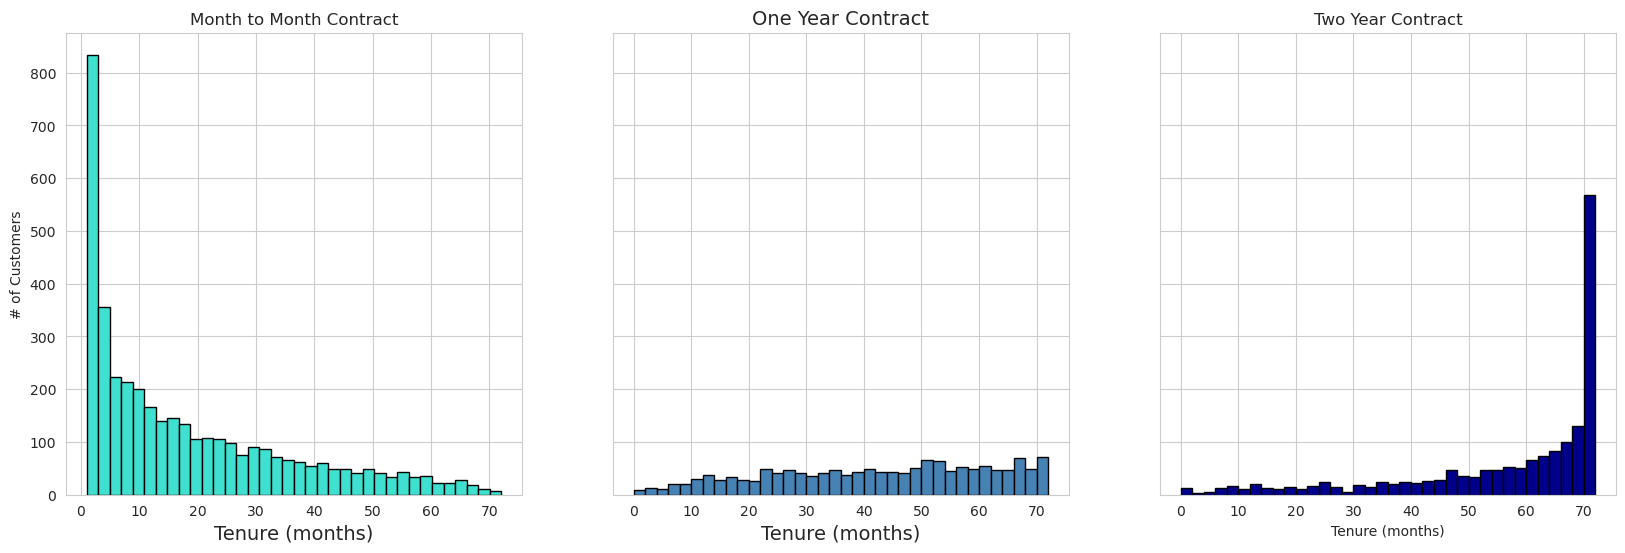

In [14]:
# Convert Spark dataframe to Pandas dataframe
pandasDF = rawdata.toPandas()

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

# Month to Month Contract
data_monthly = rawdata.filter(rawdata.Contract == 'Month-to-month')
tenure_monthly = data_monthly.select('tenure').rdd.flatMap(lambda x: x).collect()
ax1.hist(tenure_monthly, bins=int(180/5), color='turquoise', edgecolor='black')
ax1.set_xlabel('Tenure (months)', size=14)
ax1.set_ylabel('# of Customers')
ax1.set_title('Month to Month Contract')

# One Year Contract
data_one_year = rawdata.filter(rawdata.Contract == 'One year')
tenure_one_year = data_one_year.select('tenure').rdd.flatMap(lambda x: x).collect()
ax2.hist(tenure_one_year, bins=int(180/5), color='steelblue', edgecolor='black')
ax2.set_xlabel('Tenure (months)', size=14)
ax2.set_title('One Year Contract', size=14)

# Two Year Contract
data_two_year = rawdata.filter(rawdata.Contract == 'Two year')
tenure_two_year = data_two_year.select('tenure').rdd.flatMap(lambda x: x).collect()
ax3.hist(tenure_two_year, bins=int(180/5), color='darkblue', edgecolor='black')
ax3.set_xlabel('Tenure (months)')
ax3.set_title('Two Year Contract')

In [15]:
#Part 2 data cleaning

In [16]:
#convert TotalCharges to float
data= rawdata.withColumn("TotalCharges", col("TotalCharges").cast("float"))

In [17]:
#remove rows with tenure<0
data= data.filter(col("tenure")>=0)
#Drop NA gender line
data=data.filter(data.gender !="NA")
#Drop NA DeviceProtection line
data=data.filter(data.DeviceProtection !="NA")
#Drop NA Contract line
data=data.filter(data.Contract !="NA")

In [18]:
data = data.where(data.MonthlyCharges < 500)
data = data.where(data.TotalCharges < 25000)
data = data.where(data.tenure < 200)

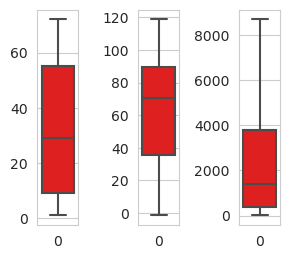

In [19]:
display_outliers(data)

In [20]:
#PART 3 : Feature engineering

In [21]:
#Change the target from string to binary
data = data.withColumn("churn_numeric", when(data.Churn == "Yes", 1).otherwise(0))

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Columns to be indexed and encoded
categorical_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
    'PaperlessBilling', 'PaymentMethod'
]

# Create indexers and encoders for all categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Num") for col in categorical_columns]
encoders = [OneHotEncoder(inputCols=[f"{col}_Num"], outputCols=[f"{col}_Vector"]) for col in categorical_columns]

# Assemble features
numeric_columns = ["tenure", "MonthlyCharges", "TotalCharges"]
assembler_inputs = [f"{col}_Vector" for col in categorical_columns] + numeric_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [23]:
# Modeling
logreg = LogisticRegression(labelCol="churn_numeric")

# Create the pipeline
pipeline_stages = indexers + encoders + [assembler, logreg]
pipeline = Pipeline(stages=pipeline_stages)

# Split the data for training and testing
trainDf, testDf = data.randomSplit([0.75, 0.25])

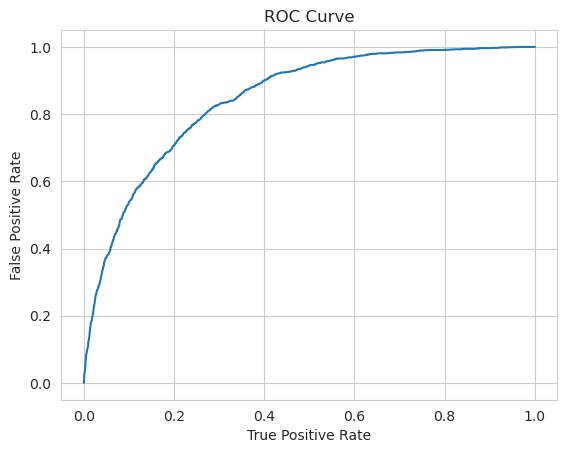

Training set areaUnderROC: 0.8455627881980837


In [24]:
# Résultats
model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [25]:
results = model.transform(testDf)

results.select("churn_numeric","prediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.churn_numeric), row.prediction))

+-------------+----------+-----------------------------------------+
|churn_numeric|prediction|probability                              |
+-------------+----------+-----------------------------------------+
|1            |1.0       |[0.3248561004290737,0.6751438995709262]  |
|0            |0.0       |[0.9427215103300324,0.057278489669967625]|
|0            |0.0       |[0.9682719023344779,0.03172809766552209] |
|0            |0.0       |[0.9922352509583315,0.007764749041668462]|
|0            |0.0       |[0.9745824048400424,0.025417595159957562]|
|1            |0.0       |[0.6697610466065131,0.33023895339348686] |
|0            |0.0       |[0.8568651441144981,0.1431348558855019]  |
|1            |0.0       |[0.5101242394039424,0.48987576059605764] |
|0            |0.0       |[0.9059934882759149,0.09400651172408514] |
|0            |0.0       |[0.9351414981951506,0.06485850180484942] |
|0            |0.0       |[0.9763642395155357,0.023635760484464252]|
|0            |0.0       |[0.88686

In [26]:
# Récupération des métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix:\n %s" % metrics.confusionMatrix().toArray())
print()
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print()
print("Accuracy = %s" % metrics.accuracy)

Confusion matrix:
 [[1132.  206.]
 [ 110.  248.]]

True negative: 1132.0
False positive: 206.0
False negative: 110.0
True positive: 248.0

Accuracy = 0.8136792452830188


In [27]:
from pyspark.sql import DataFrame
# Define function for undersampling
def undersample(data: DataFrame, label_col: str, majority_label: str, minority_label: str) -> DataFrame:
    majority_df = data.filter(col(label_col) == majority_label)
    minority_df = data.filter(col(label_col) == minority_label)

    majority_sample_count = minority_df.count()

    # Get a fraction to undersample the majority class
    fraction = majority_sample_count / majority_df.count()

    majority_df_sampled = majority_df.sample(fraction)

    # Combine the undersampled majority class with the minority class
    balanced_data = majority_df_sampled.union(minority_df)
    
    return balanced_data

# Apply the undersampling function
balanced_data = undersample(data, 'churn', 'No', 'Yes')

# Show the count of 'yes' and 'no' values after undersampling
balanced_data.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|   No| 1876|
|  Yes| 1872|
+-----+-----+



In [28]:
# Columns to be indexed and encoded
categorical_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
    'PaperlessBilling', 'PaymentMethod'
]

# Create indexers and encoders for all categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Num") for col in categorical_columns]
encoders = [OneHotEncoder(inputCols=[f"{col}_Num"], outputCols=[f"{col}_Vector"]) for col in categorical_columns]

# Assemble features
numeric_columns = ["tenure", "MonthlyCharges", "TotalCharges"]
assembler_inputs = [f"{col}_Vector" for col in categorical_columns] + numeric_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [32]:
# Modeling
logreg = LogisticRegression(labelCol="churn_numeric")

# Create the pipeline
pipeline_stages = indexers + encoders + [assembler, logreg]
pipeline = Pipeline(stages=pipeline_stages)

# Split the data for training and testing
trainDf, testDf = balanced_data.randomSplit([0.75, 0.25])

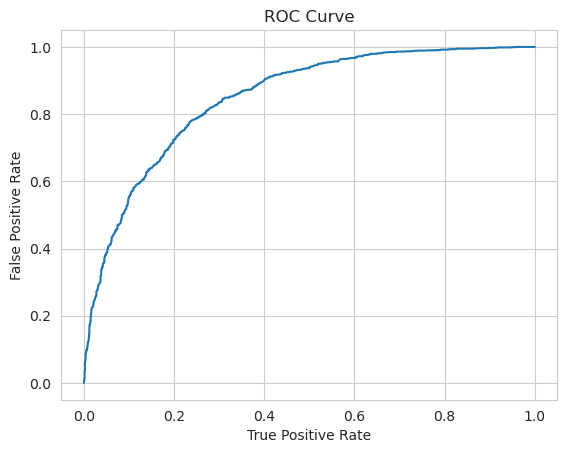

Training set areaUnderROC: 0.848364072105868


In [33]:
# Résultats
model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [35]:
results = model.transform(testDf)

results.select("churn_numeric","prediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.churn_numeric), row.prediction))

+-------------+----------+------------------------------------------+
|churn_numeric|prediction|probability                               |
+-------------+----------+------------------------------------------+
|0            |0.0       |[0.6775914261637259,0.3224085738362741]   |
|0            |0.0       |[0.8715657301628967,0.12843426983710327]  |
|0            |0.0       |[0.9491446131107121,0.050855386889287924] |
|0            |0.0       |[0.8127902290894052,0.18720977091059476]  |
|0            |1.0       |[0.32763901602651235,0.6723609839734876]  |
|0            |0.0       |[0.7678845300784639,0.2321154699215361]   |
|0            |1.0       |[0.19872230622944817,0.8012776937705518]  |
|0            |0.0       |[0.9849573991723513,0.015042600827648744] |
|0            |0.0       |[0.7170923952620964,0.28290760473790355]  |
|0            |0.0       |[0.9711184898295911,0.028881510170408853] |
|0            |0.0       |[0.859013595844752,0.140986404155248]     |
|0            |0.0  

In [36]:
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix:\n %s" % metrics.confusionMatrix().toArray())
print()
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print()
print("Accuracy = %s" % metrics.accuracy)

Confusion matrix:
 [[331. 100.]
 [131. 401.]]

True negative: 331.0
False positive: 100.0
False negative: 131.0
True positive: 401.0

Accuracy = 0.7601246105919003


In [38]:
# Replace LogisticRegression with GBTClassifier
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="churn_numeric")

In [39]:
# Create the pipeline
pipeline_stages = indexers + encoders + [assembler, logreg]
pipeline = Pipeline(stages=pipeline_stages)

# Split the data for training and testing
trainDf, testDf = balanced_data.randomSplit([0.75, 0.25])

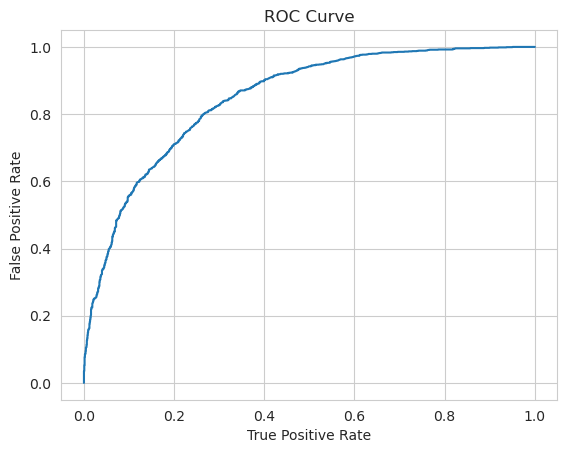

Training set areaUnderROC: 0.8477576162170647


In [40]:
# Résultats
model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [42]:
results = model.transform(testDf)

results.select("churn_numeric","prediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.churn_numeric), row.prediction))

+-------------+----------+-----------------------------------------+
|churn_numeric|prediction|probability                              |
+-------------+----------+-----------------------------------------+
|0            |0.0       |[0.680318549681776,0.31968145031822404]  |
|0            |0.0       |[0.9910997032333816,0.00890029676661841] |
|0            |0.0       |[0.9955076543712101,0.004492345628789862]|
|0            |0.0       |[0.5122579459438513,0.4877420540561487]  |
|0            |1.0       |[0.33237388669765866,0.6676261133023413] |
|0            |0.0       |[0.904063811796373,0.09593618820362704]  |
|0            |1.0       |[0.2810088483680969,0.7189911516319031]  |
|0            |0.0       |[0.9378525982555797,0.06214740174442035] |
|0            |0.0       |[0.9814215087825162,0.018578491217483784]|
|0            |0.0       |[0.9407272809956422,0.05927271900435782] |
|0            |1.0       |[0.4151104575880003,0.5848895424119998]  |
|0            |0.0       |[0.86576

In [43]:
# Récupération des métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix:\n %s" % metrics.confusionMatrix().toArray())
print()
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print()
print("Accuracy = %s" % metrics.accuracy)

Confusion matrix:
 [[334.  71.]
 [141. 364.]]

True negative: 334.0
False positive: 71.0
False negative: 141.0
True positive: 364.0

Accuracy = 0.7670329670329671
